# VGG-16 Model Trained with Transfer Learning

This file is used to train a VGG-16 model with transfer learning on the adapted cars dataset (49 classes, images cropped around the bounding boxes, and 50% more training data). 

We used a model with weights pre-trained on the ImageNet dataset.

In [1]:
# importing libaries
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import pandas as pd
import cv2
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten
from keras.applications.vgg16 import VGG16

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
%cd /content/gdrive/MyDrive/Kaggle/data
!unzip \*.zip  && rm *.zip

In [10]:
gen_params = {"rescale":1.0/255,
              "featurewise_center":False,
              "samplewise_center":False,
              "featurewise_std_normalization":False,
              "samplewise_std_normalization":False,
              "zca_whitening":False,
              "rotation_range":20,
              "width_shift_range":0.1,
              "height_shift_range":0.1,
              "shear_range":0.2,
              "zoom_range":0.1,
              "horizontal_flip":True,
              "fill_mode":'constant',
              "cval": 0,
              "validation_split":0.25}

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**gen_params)

test_params = {"rescale":1.0/255,}
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**test_params)


## Data generator for training images
train_generator = train_datagen.flow_from_directory('/content/gdrive/MyDrive/Kaggle/data/car_data/train/',
                                                    class_mode='categorical', batch_size = 32,
                                                    target_size=(224,224),color_mode='rgb',shuffle = True,subset='training')

val_generator = train_datagen.flow_from_directory('/content/gdrive/MyDrive/Kaggle/data/car_data/train/',
                                                    class_mode='categorical', batch_size = 32, 
                                                    target_size=(224,224),color_mode='rgb',shuffle = True,subset='validation')

test_generator = test_datagen.flow_from_directory('/content/gdrive/MyDrive/Kaggle/data/car_data/test/',
                                                    class_mode='categorical', batch_size = 32,
                                                    target_size=(224,224),color_mode='rgb',shuffle = True)

Found 9138 images belonging to 49 classes.
Found 3021 images belonging to 49 classes.
Found 4026 images belonging to 49 classes.


In [11]:
def build_vgg16_transfer_learning_model(img_height=224,img_width=224,num_classes=49):

    # base model
    base_model = tf.keras.applications.VGG16(
        weights='imagenet',
        input_shape=(img_height, img_width, 3),
        include_top=False) 
    base_model.trainable = False

    # add the top
    input_image = tf.keras.Input(shape=(img_height, img_width, 3))
    x1 = base_model(input_image, training=False)
    x2 = tf.keras.layers.Flatten()(x1)
    out = tf.keras.layers.Dense(num_classes,activation = 'softmax')(x2)
    model = tf.keras.Model(inputs = input_image, outputs =out)
  
    #compile and return
    model.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-4),loss='categorical_crossentropy',metrics=['accuracy'])
    
    return model

In [12]:
model = build_vgg16_transfer_learning_model()
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 49)                1229361   
Total params: 15,944,049
Trainable params: 1,229,361
Non-trainable params: 14,714,688
_________________________________________________________________


In [13]:
model_name = "vgg16_cars_49_classes_cropped.h5"
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 20)

monitor = tf.keras.callbacks.ModelCheckpoint(model_name, monitor='val_loss',\
                                             verbose=0,save_best_only=True,\
                                             save_weights_only=True,\
                                             mode='min')
# Learning rate schedule
def scheduler(epoch, lr):
    if epoch%4 == 0 and epoch!= 0:
        lr = lr/2
    return lr

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose = 0)

In [14]:
batch = 128
num_epochs = 100

history = model.fit(train_generator,
                    validation_data = val_generator,
                    epochs=num_epochs,
                    verbose=1,
                    batch_size=batch,
                    callbacks=[early_stop,monitor,lr_schedule])

Epoch 1/100
286/286 [==============================] - 167s 582ms/step - loss: 3.4192 - accuracy: 0.1199 - val_loss: 2.8033 - val_accuracy: 0.2526
Epoch 2/100
286/286 [==============================] - 163s 570ms/step - loss: 2.6397 - accuracy: 0.2940 - val_loss: 2.4467 - val_accuracy: 0.3244
Epoch 3/100
286/286 [==============================] - 162s 567ms/step - loss: 2.2685 - accuracy: 0.3882 - val_loss: 2.2142 - val_accuracy: 0.3919
Epoch 4/100
286/286 [==============================] - 163s 569ms/step - loss: 1.9909 - accuracy: 0.4719 - val_loss: 2.0934 - val_accuracy: 0.4085
Epoch 5/100
286/286 [==============================] - 163s 569ms/step - loss: 1.8057 - accuracy: 0.5233 - val_loss: 1.9592 - val_accuracy: 0.4777
Epoch 6/100
286/286 [==============================] - 163s 569ms/step - loss: 1.7033 - accuracy: 0.5612 - val_loss: 1.8948 - val_accuracy: 0.4916
Epoch 7/100
286/286 [==============================] - 162s 568ms/step - loss: 1.6509 - accuracy: 0.5772 - val_loss: 1

In [15]:
## finetune model
base_model = tf.keras.applications.VGG16(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(224,224,3),
    include_top=False) 
base_model.trainable = True
input_image = tf.keras.Input(shape=(224,224,3))
x1 = base_model(input_image, training=True)
x2 = tf.keras.layers.Flatten()(x1)
out = tf.keras.layers.Dense(49,activation = 'softmax')(x2)
model = tf.keras.Model(input_image, out)
print(model.summary())

model.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-6),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.load_weights(model_name)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 49)                1229361   
Total params: 15,944,049
Trainable params: 15,944,049
Non-trainable params: 0
_________________________________________________________________
None


In [16]:
batch = 128
num_epochs = 100
history_2 = model.fit(train_generator,
          validation_data = val_generator,
          epochs=num_epochs,
          verbose=1,
          batch_size=batch,
          callbacks=[early_stop,monitor,lr_schedule])

Epoch 1/100
286/286 [==============================] - 166s 574ms/step - loss: 1.1580 - accuracy: 0.6789 - val_loss: 1.3977 - val_accuracy: 0.6015
Epoch 2/100
286/286 [==============================] - 163s 570ms/step - loss: 0.9811 - accuracy: 0.7105 - val_loss: 1.3474 - val_accuracy: 0.6097
Epoch 3/100
286/286 [==============================] - 163s 570ms/step - loss: 0.8997 - accuracy: 0.7325 - val_loss: 1.2992 - val_accuracy: 0.6273
Epoch 4/100
286/286 [==============================] - 163s 568ms/step - loss: 0.8749 - accuracy: 0.7389 - val_loss: 1.2979 - val_accuracy: 0.6230
Epoch 5/100
286/286 [==============================] - 164s 572ms/step - loss: 0.8013 - accuracy: 0.7594 - val_loss: 1.2596 - val_accuracy: 0.6395
Epoch 6/100
286/286 [==============================] - 163s 569ms/step - loss: 0.7948 - accuracy: 0.7600 - val_loss: 1.2514 - val_accuracy: 0.6548
Epoch 7/100
286/286 [==============================] - 163s 570ms/step - loss: 0.7758 - accuracy: 0.7626 - val_loss: 1

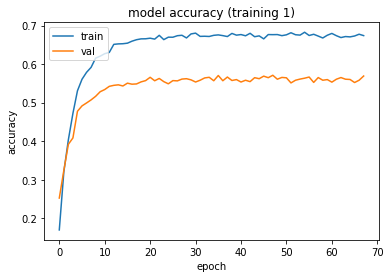

In [17]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy (training 1)')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [18]:
model.load_weights('/content/gdrive/MyDrive/Kaggle/data/vgg16_cars_49_classes_cropped.h5')
metrics = model.evaluate(test_generator)

126/126 [==============================] - 26s 209ms/step - loss: 1.0663 - accuracy: 0.7052


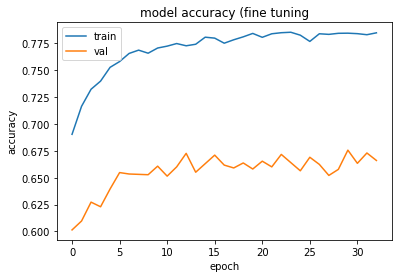

In [19]:
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('model accuracy (fine tuning')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

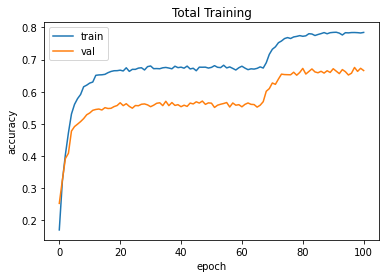

In [20]:
acc_total = np.zeros(len(history.history['accuracy']) + len(history_2.history['accuracy']))
val_total = np.zeros(len(history.history['val_accuracy']) + len(history_2.history['val_accuracy']))

for i in range(len(history.history['accuracy'])):
  acc_total[i] = history.history['accuracy'][i]
  val_total[i] = history.history['val_accuracy'][i]
  
for j in range(len(history_2.history['accuracy'])):
  acc_total[j+len(history.history['accuracy'])] = history_2.history['accuracy'][j]
  val_total[j+len(history.history['val_accuracy'])] = history_2.history['val_accuracy'][j]



plt.plot(acc_total)
plt.plot(val_total)
plt.title('Total Training')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()  

In [21]:
max(history_2.history['val_accuracy'])

0.6756041049957275

In [22]:
max(history_2.history['accuracy'])

0.785182774066925